# Galaxy Selection for Cross-Correlation with 2017 CLAMATO data

These are the approx map boundaries for the tomographic map. These are where most of the sightlines are, although we will also pick galaxies somewhat outside to include more data for large-scale cross-correlations.

In [29]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table

from fnmatch import fnmatch

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc('mathtext',fontset='stixsans')
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

ra0 = 149.950000
dec0 = 2.150000
ra1 = 150.390000
dec1 = 2.5010000

# degrees per transverse Mpc/h
deg_per_hMpc = 1./ cosmo.h / cosmo.comoving_distance(2.35).value * 180./np.pi
print(cosmo.comoving_distance(2.35))

# Look for galaxies up to 15Mpc/h transverse from the central map region
d_ra  = 15. * deg_per_hMpc
d_dec = 15. * deg_per_hMpc


5595.982139921013 Mpc


Redshift range to consider. This is a bit broader than the redshift range used in the tomographic map since we don't need such a high sightline density.

In [30]:
zmin = 2.0
zmax = 2.6

Get MOSDEF galaxies. These are our top priority redshifts.

ColDefs(
    name = 'FIELD'; format = '7A'
    name = 'ID_V2'; format = 'J'
    name = 'ID_V4'; format = 'J'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'Z_MOSFIRE'; format = 'E'
    name = 'MASKNAME'; format = '6A'
    name = 'TARGET'; format = 'J'
)
There are 121 coeval galaxies from MOSDEF


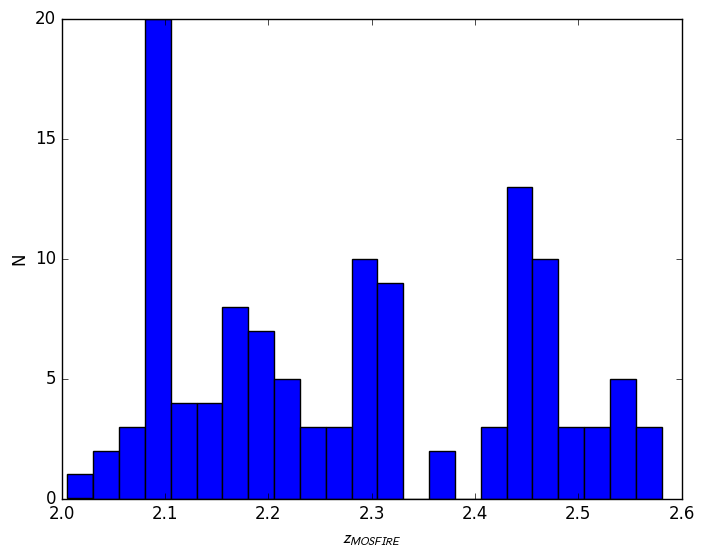

In [31]:
catdir = '/Users/kheegan/lya/3d_recon/ts/ts_cats/'
mosdef2016_fil = catdir+'mosdef_zcat.16aug2016.fits'
#mosdef2015_fil = catdir+'mosdef_zcat.1oct2015.fits'

catmd = fits.open(mosdef2016_fil)

print(catmd[1].columns)

#catmd[1]

catmddata = catmd[1].data

# filter for COSMOS galaxies in the right redshift 
getcosmos = catmddata['FIELD'] == 'COSMOS' 
lowzcut = catmddata['Z_MOSFIRE'] >= zmin
hizcut  = catmddata['Z_MOSFIRE'] < zmax
racut1 = catmddata['RA']> (ra0 - d_ra)
racut2 = catmddata['RA']< (ra1 + d_ra)
deccut1 = catmddata['DEC']> (dec0 - d_ra) 
deccut2 = catmddata['DEC']< (dec1 + d_ra)

allcuts = lowzcut & getcosmos & hizcut & racut1 & racut2 & deccut1 & deccut2

catmddata = catmddata[allcuts]

# Remove objects with duplicate observations from different MOSDEF masks
tmp, u_ind = np.unique(catmddata['ID_V4'], return_index=True)
catmddata = catmddata[u_ind]

ra_md  = catmddata['RA']
dec_md = catmddata['DEC']
MosdefCoord = SkyCoord(ra=ra_md*u.degree, dec=dec_md*u.degree)

#coord= plt.scatter(ra_md, dec_md, marker='o')
print('There are '+str(len(catmddata))+' coeval galaxies from MOSDEF')

fig, ax = plt.subplots()
binwidth=0.025
ax.hist(catmddata['Z_MOSFIRE'],bins=np.arange(min(catmddata['Z_MOSFIRE']),
                                               max(catmddata['Z_MOSFIRE']) + binwidth, binwidth))
ax.set_xlabel(r'$z_{MOSFIRE}$')
ax.set_ylabel('N')
plt.show()

Grab VUDS galaxies...

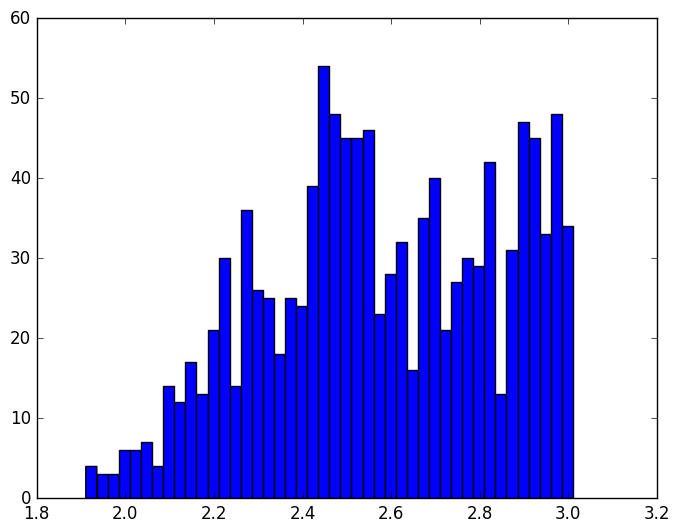

435 galaxies after redshift, quality and positional cuts


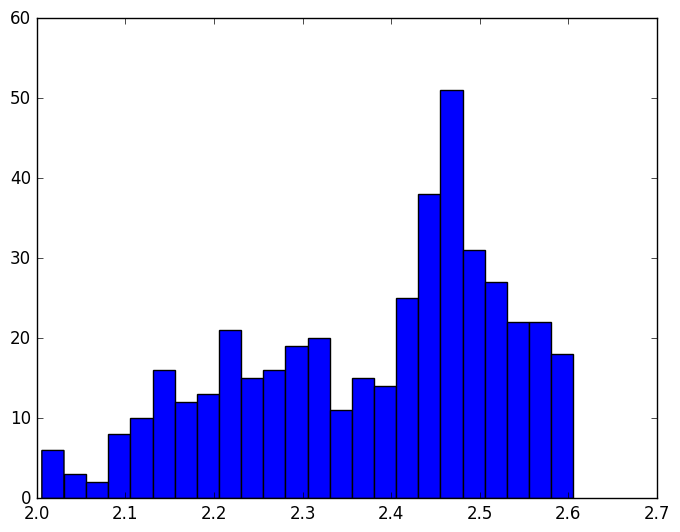

7 VUDS galaxies are also measured by MOSDEF
This leaves 428 VUDS galaxies in our sample


In [32]:
vuds_specz_fil = '/Users/kheegan/lya/3d_recon/ts/ts_cats/cesam_vuds_spectra_cosmos_catalog_1489008861.txt'

vuds = ascii.read(vuds_specz_fil,format='fast_commented_header',header_start=-1)

#print(np.sum(flag_z_vuds == 24))

fig, ax = plt.subplots()
zspec = vuds['z_spec']
binwidth=0.025
plt.hist(zspec, bins=np.arange(min(zspec), max(zspec) + binwidth, binwidth))
plt.show()

#redshift, quality and coordinate cuts
zcut = np.all(np.column_stack([(vuds['z_spec'] >= zmin) ,
                            (vuds['z_spec'] < zmax),
                            (vuds['alpha'] >= ra0-d_ra),
                            (vuds['alpha'] <= ra1+d_ra),
                              (vuds['delta'] >= dec0-d_dec),
                              (vuds['delta'] <= dec1+d_dec)]), axis=1)
                             #(vuds['zflags'] >=3),
                             #(vuds['zflags'] < 9)]),axis=1) 


vuds = vuds[zcut]
print('%i galaxies after redshift, quality and positional cuts' % len(vuds))

fig, ax = plt.subplots()
zspec = vuds['z_spec']
binwidth=0.025
plt.hist(zspec, bins=np.arange(min(zspec), max(zspec) + binwidth, binwidth))
plt.show()

# Match coordinates with MOSDEF sample, and throw away any that match
vudsCoord = SkyCoord(ra=vuds['alpha']*u.degree,dec=vuds['delta']*u.degree)

idv, d2d , d3d = vudsCoord.match_to_catalog_sky(MosdefCoord)

closematch_vuds = d2d < (1*u.arcsec)
notmatch_vuds = np.invert(closematch_vuds)

print('%i VUDS galaxies are also measured by MOSDEF' % sum(1 for i in closematch_vuds if i))

vuds = vuds[notmatch_vuds]
vudsCoord = vudsCoord[notmatch_vuds]
print('This leaves %i VUDS galaxies in our sample' % len(vuds))

Now grab zCOSMOS-Deep galaxies...

[('Instr', '<U10'), ('ra', '<f8'), ('dec', '<f8'), ('ORI_ID', '<U25'), ('z_spec', '<f8'), ('Q_f', '<f8'), ('OPT_ID', '<i8'), ('ra_opt', '<f8'), ('dec_opt', '<f8'), ('Separation', '<f8'), ('group_id', '<i8'), ('group_size', '<i8'), ('Contact', '<U58')]
2602 galaxies after redshift and positional cuts
511 galaxies within zCOSMOS-Deep after quality cuts
10 zDeep galaxies are also measured by MOSDEF
10 zDeep galaxies are also measured by VUDS
This leaves 491 zDeep galaxies in our sample


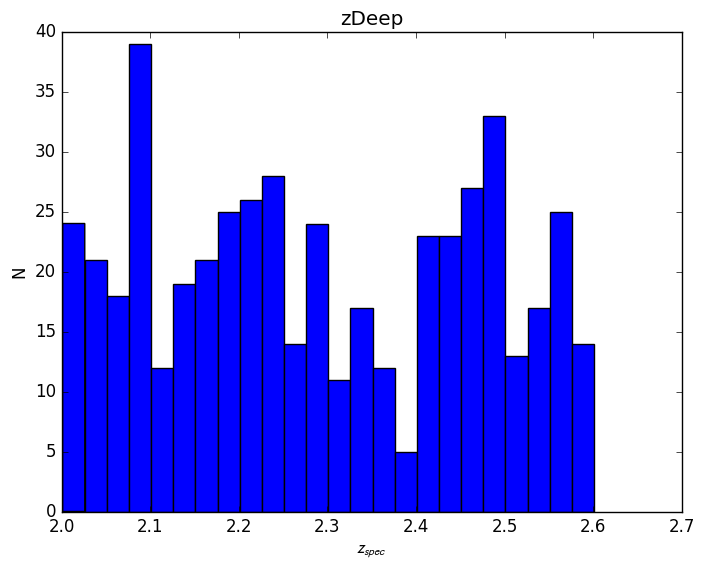

In [33]:
cosmos_specz_fil = '/Users/kheegan/scratch/cosmos/spec/'+\
'OBSERVED_TARGETS_15April2015_withHeader.dat'

cosmos = ascii.read(cosmos_specz_fil,format='fast_commented_header',header_start=-1)

print(cosmos.dtype)
#(set(cosmos['Instr']))

# make redshift and coordinate cuts
zcut = np.all(np.column_stack([(cosmos['z_spec'] >= zmin) ,
                            (cosmos['z_spec'] < zmax),
                            (cosmos['ra'] >= ra0-d_ra),
                            (cosmos['ra'] <= ra1+d_ra),
                              (cosmos['dec'] >= dec0-d_dec),
                              (cosmos['dec'] <= dec1+d_dec)]),axis=1)              
              
cosmos = cosmos[zcut]
print('%i galaxies after redshift and positional cuts' % len(cosmos))
#print(np.shape(cosmos))
# print(cosmos.meta) # These are the comments

#fig, ax = plt.subplots()
zspec = cosmos['z_spec']
binwidth=0.025
#plt.hist(zspec,bins=np.arange(min(zspec), max(zspec) + binwidth, binwidth))
#plt.show()

#[fnmatch(instr,'MOS*') for instr in cosmos['Instr']]

# get high-confidence (>3) redshifts from zCOSMOSDeep for galaxies only
confcut = np.all(np.column_stack(( (cosmos['Instr'] == 'zDEEP'),
                                   (cosmos['Q_f'] >= 3.),
                                   (cosmos['Q_f'] < 10.) )), axis=1)

cosmos = cosmos[confcut]
print('%i galaxies within zCOSMOS-Deep after quality cuts' % len(cosmos))

# Match coordinates with MOSDEF sample, and throw away any that match
zDeepCoord = SkyCoord(ra=cosmos['ra']*u.degree,dec=cosmos['dec']*u.degree)

idzD, d2d , d3d = zDeepCoord.match_to_catalog_sky(MosdefCoord)

SepUnit= u.arcmin
#plt.hist(d2d.to(SepUnit))
#plt.title('Separation from MOSDEF Objects')
#plt.xlabel("Separation "+"({0.unit:s})".format(1.*SepUnit))
#plt.show()

closematch_zD = d2d < (1*u.arcsec)
notmatch_zD = np.invert(closematch_zD)

print('%i zDeep galaxies are also measured by MOSDEF' % sum(1 for i in closematch_zD if i))

#Match coordinates with VUDS sample
id_zD2, d2d_zD2 , d3d_zD2 = zDeepCoord.match_to_catalog_sky(vudsCoord)
notmatch_zD2 = d2d_zD2 >= 1.*u.arcsec
print("%i zDeep galaxies are also measured by VUDS" % sum(1 for j in notmatch_zD2 if not j))

notmatch_atall = np.all(np.column_stack([notmatch_zD,notmatch_zD2]), axis=1)

cosmos = cosmos[notmatch_atall]
zDeepCoord = zDeepCoord[notmatch_atall]
print('This leaves %i zDeep galaxies in our sample' % len(cosmos))

fig, ax = plt.subplots()
binwidth=0.025
ax.hist(cosmos['z_spec'],bins=np.arange(min(cosmos['z_spec']),
                                               max(cosmos['z_spec']) + binwidth, binwidth))
ax.set_xlabel(r'$z_{spec}$')
ax.set_ylabel('N')
ax.set_title('zDeep')
plt.show()

Get CLAMATO redshifts

168 galaxies after redshift and quality cuts
10 CLAMATO galaxies are also measured by MOSDEF
17 CLAMATO galaxies are also measured by VUDS
40 CLAMATO galaxies are also measured by zDeep
This leaves 101 CLAMATO galaxies in our sample


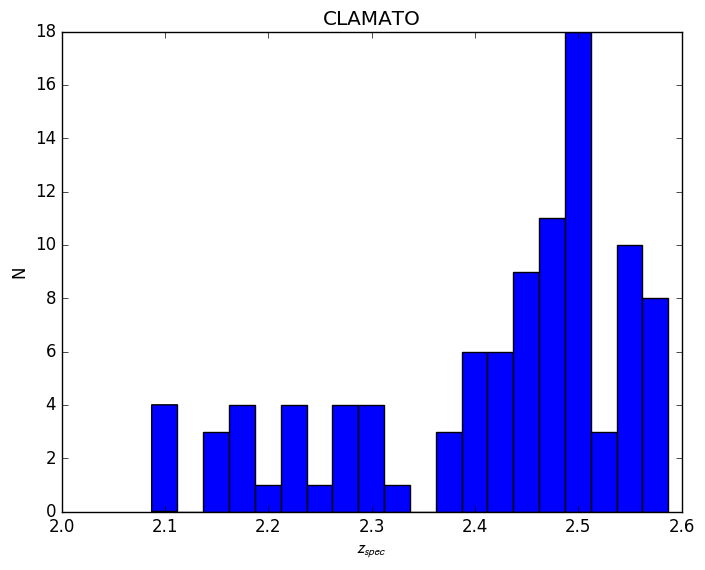

In [34]:
clamato_specz_fil = '/Users/kheegan/lya/3d_recon/data/cl2017_redux/cl2017_valueadded_20170426.txt'

clamato = ascii.read(clamato_specz_fil,format='fast_commented_header',header_start=-1)

#Make redshift and quality cuts
zcut = np.all(np.column_stack([(clamato['zspec'] >= zmin) ,
                            (clamato['zspec'] < zmax),
                            (clamato['Conf'] >=3),
                              (clamato['Conf'] <10)]),axis=1)              
              
clamato = clamato[zcut]
print('%i galaxies after redshift and quality cuts' % len(clamato))

# Match coordinates with MOSDEF sample, and throw away any that match
ClamatoCoord = SkyCoord(ra=clamato['RA']*u.degree,dec=clamato['Dec']*u.degree)

id_cl, d2d_cl , d3d_cl = ClamatoCoord.match_to_catalog_sky(MosdefCoord)

SepUnit= u.arcmin
#plt.hist(d2d.to(SepUnit))
#plt.title('Separation from MOSDEF Objects')
#plt.xlabel("Separation "+"({0.unit:s})".format(1.*SepUnit))
#plt.show()

closematch_cl = d2d_cl < (1*u.arcsec)
notmatch_cl = np.invert(closematch_cl)

print('%i CLAMATO galaxies are also measured by MOSDEF' % sum(1 for i in closematch_cl if i))

#Match coordinates with VUDS sample
id_cl2, d2d_cl2 , d3d_cl2 = ClamatoCoord.match_to_catalog_sky(vudsCoord)
notmatch_cl2 = d2d_cl2 >= 1.*u.arcsec
print("%i CLAMATO galaxies are also measured by VUDS" % sum(1 for j in notmatch_cl2 if not j))

#Match coordinates with zDEEP sample
id_cl3, d2d_cl3 , d3d_cl3 = ClamatoCoord.match_to_catalog_sky(zDeepCoord)
notmatch_cl3 = d2d_cl3 >= 1.*u.arcsec
print("%i CLAMATO galaxies are also measured by zDeep" % sum(1 for j in notmatch_cl3 if not j))

notmatch_atall = np.all(np.column_stack([notmatch_cl,notmatch_cl2,notmatch_cl3]), axis=1)

clamato = clamato[notmatch_atall]
ClamatoCoord = ClamatoCoord[notmatch_atall]
print('This leaves %i CLAMATO galaxies in our sample' % len(clamato))

fig, ax = plt.subplots()
binwidth=0.025
ax.hist(clamato['zspec'],bins=np.arange(min(clamato['zspec']),
                                               max(clamato['zspec']) + binwidth, binwidth))
ax.set_xlabel(r'$z_{spec}$')
ax.set_ylabel('N')
ax.set_title('CLAMATO')
plt.show()

Now ingest 3D-HST redshifts. Need to read in grism-z AND photometric redshifts separately and match them. We demand that FLAG1 and FLAG2 are both 0, which means that two people have signed off on each spectrum.


325 3D-HST galaxies pass basic cuts
56 already have MOSDEF redshifts
24 already have zDeep redshifts
14 already have VUDS redshifts
5 already have CLAMATO redshifts
There are therefore 226 unique redshifts from 3D-HST grisms


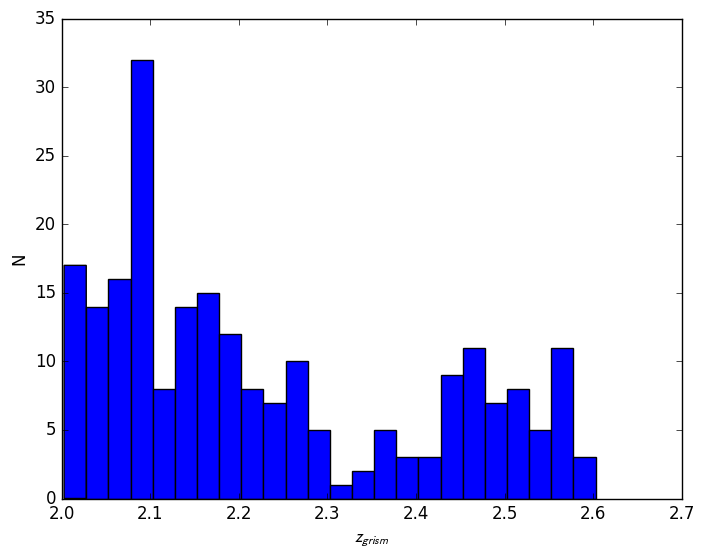

In [35]:
grismdir = '/Users/kheegan/scratch/cosmos/spec/cosmos_3dhst_v4.1.5_catalogs/'
grismfil = grismdir+'cosmos_3dhst.v4.1.5.zfit.linematched.fits'

phot3d_dir = '/Users/kheegan/scratch/cosmos/phot/cosmos_3dhst.v4.1.cats/Catalog/'
phot3d_fil = phot3d_dir+'cosmos_3dhst.v4.1.cat.FITS'

grism3d_tmp = fits.open(grismfil)
phot3d_tmp = fits.open(phot3d_fil)

#print(len(grism3d_tmp[1].data), len(phot3d[1].data))
#print(grism3d_tmp[1].columns)

grism3d = grism3d_tmp[1].data
phot3d  = phot3d_tmp[1].data

# Make cuts to grism-z's: redshift positions, and confidence... 
cut3dhst = np.all(np.column_stack([(grism3d['z_max_grism'] >= zmin),
                                  (grism3d['z_max_grism']<=zmax),
                                   (grism3d['flag1']==0),
                                   (grism3d['flag2']==0),
                                   (phot3d['ra'] >= ra0 - d_ra),
                                   (phot3d['ra'] <= ra1 + d_ra),
                                   (phot3d['dec'] >= dec0 - d_dec),
                                   (phot3d['dec'] <= dec1 + d_dec)
                                  ]) , axis=1)

grism3d = grism3d[cut3dhst]
phot3d  = phot3d[cut3dhst]
print('%i 3D-HST galaxies pass basic cuts' % len(grism3d))

# MAtch coordinates with MOSDEF sample
grismCoord = SkyCoord(ra=phot3d['ra']*u.degree, dec=phot3d['dec']*u.degree)

id_gr1, d2d_gr1 , d3d_gr1 = grismCoord.match_to_catalog_sky(MosdefCoord)
notmatch_gr1 = d2d_gr1 >= 1.*u.arcsec
match_gr1 = d2d_gr1 < 1.*u.arcsec
# Verify that ID_V4 in the MOSDEF catalog is indeed PHOT_ID in the 3D-HST 2015 catalog
#idmd = catmddata['ID_V4']
#idgrism = grism3d['phot_id']
#print('\n'.join('\t'.join(map(str,row)) \
#                for row in zip(idmd[id_gr1[match_gr1]],idgrism[match_gr1])))

print("%i already have MOSDEF redshifts" % sum(1 for j in notmatch_gr1 if not j))

#Match coordinates with zDeep sample
id_gr2, d2d_gr2 , d3d_gr2 = grismCoord.match_to_catalog_sky(zDeepCoord)
notmatch_gr2 = d2d_gr2 >= 1.*u.arcsec
print("%i already have zDeep redshifts" % sum(1 for j in notmatch_gr2 if not j))

#Match coordinates with VUDS sample
id_gr3, d2d_gr3 , d3d_gr3 = grismCoord.match_to_catalog_sky(vudsCoord)
notmatch_gr3 = d2d_gr3 >= 1.*u.arcsec
print("%i already have VUDS redshifts" % sum(1 for j in notmatch_gr3 if not j))

#Match coordinates with CLAMATO sample
id_gr4, d2d_gr4 , d3d_gr4 = grismCoord.match_to_catalog_sky(ClamatoCoord)
notmatch_gr4 = d2d_gr4 >= 1.*u.arcsec
print("%i already have CLAMATO redshifts" % sum(1 for j in notmatch_gr4 if not j))

notmatch_atall = np.all(np.column_stack([notmatch_gr1,notmatch_gr2,notmatch_gr3,notmatch_gr4]), axis=1)
grism3d = grism3d[notmatch_atall]
phot3d  = phot3d[notmatch_atall]

print('There are therefore %i unique redshifts from 3D-HST grisms' % len(grism3d))

fig, ax = plt.subplots()
binwidth=0.025
ax.hist(grism3d['z_max_grism'],bins=np.arange(min(grism3d['z_max_grism']),
                                               max(grism3d['z_max_grism']) + binwidth, binwidth))
ax.set_xlabel(r'$z_{grism}$')
ax.set_ylabel('N')
plt.show()

Plot positions of the objects in comparison with CLAMATO tomographic map boundaries

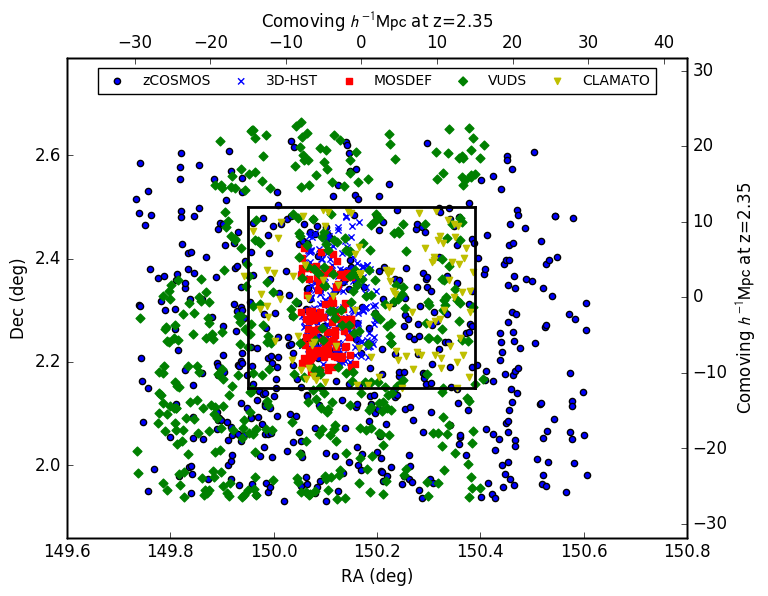

In [50]:
#Plot positions of all objects in comparison with CLAMATO map boundary
#Show 

fig, ax1 = plt.subplots()

ax1.get_xaxis().get_major_formatter().set_useOffset(False)

#Set aspect ratio 
ax1.set_aspect('equal','datalim')

pl1 = ax1.scatter(cosmos['ra'], cosmos['dec'], marker='o',label='zCOSMOS')
pl2 = ax1.scatter(phot3d['ra'], phot3d['dec'], marker='x',label='3D-HST')
pl3 = ax1.scatter(ra_md, dec_md, marker='s',color='r', label='MOSDEF')
pl4 = ax1.scatter(vuds['alpha'], vuds['delta'], marker='D', label='VUDS', color='g')
plt5 = ax1.scatter(clamato['RA'], clamato['Dec'], marker='v', label='CLAMATO', color='y')
ax1.plot([ra0,ra1],[dec0,dec0], color='k',linestyle='-', linewidth=2)
ax1.plot([ra1,ra1],[dec0,dec1], color='k',linestyle='-', linewidth=2)
ax1.plot([ra1,ra0],[dec1,dec1], color='k',linestyle='-', linewidth=2)
ax1.plot([ra0,ra0],[dec1,dec0], color='k',linestyle='-', linewidth=2)

plt.legend(bbox_to_anchor=(0.05, 0.9, 0.9, 0.102), loc=10,
           ncol=5, mode="expand", borderaxespad=0.,scatterpoints=1,fontsize='small')
#plt.legend(loc='upper right',scatterpoints=1)

ax1.set_ylabel('Dec (deg)')
ax1.set_xlabel('RA (deg)')

# Custom y-axis limits to give space for legend
ax1.set_ylim(1.85,2.8)

# Need to this to set the axis limits
plt.draw()

# Define zero-point of transverse comoving distance scale as center of tomographic map.
ramid = (ra0+ra1)/2.
decmid = (dec0+dec1)/2.


ax2 = ax1.twinx()
dec_plran = ax1.get_ylim()
ycom_min= (dec_plran[0] - decmid)/deg_per_hMpc
ycom_max= (dec_plran[1] - decmid)/deg_per_hMpc
ax2.set_ylabel('Comoving '+r'$h^{-1}\mathrm{Mpc}$'+' at z=2.35' )
ax2.set_ylim([ycom_min,ycom_max])

ax3 = ax1.twiny()
ra_plran = ax1.get_xlim()
xcom_min = (ra_plran[0] - ramid)/deg_per_hMpc
xcom_max = (ra_plran[1] - ramid)/deg_per_hMpc
ax3.set_xlabel('Comoving '+r'$h^{-1}\mathrm{Mpc}$'+' at z=2.35' )
ax3.set_xlim([xcom_min,xcom_max])

#ax3.grid(color='y', linestyle='-', linewidth=1, which='both')

plt.show()




Now combine everything into a single table, and write to ASCII. The 'ID' column lists 'ID_V4' for the MOSDEF and 3D-HST data, and 'OPT_ID' for the zCOSMOS. We will also save the 3D positions of the objects in Mpc/h, with the transverse positions relative to ra_0 and dec_0.

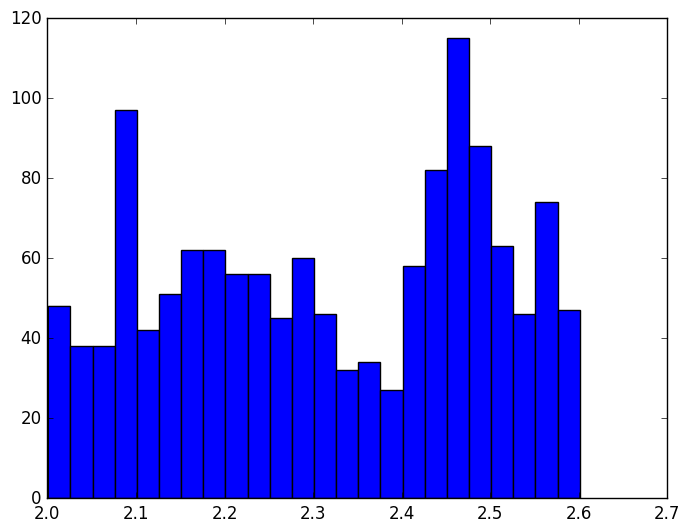

Saving 1367 galaxies


In [37]:
ra_all = np.concatenate((ra_md,cosmos['ra'],phot3d['ra'], vuds['alpha'],clamato['RA']) )
dec_all = np.concatenate((dec_md, cosmos['dec'], phot3d['dec'], vuds['delta'],clamato['Dec']))
z_all = np.concatenate((catmddata['Z_MOSFIRE'], cosmos['z_spec'], grism3d['z_max_grism'], 
                        vuds['z_spec'],clamato['zspec']) )
source_all = np.concatenate((['MOSDEF']*len(catmddata), ['zDEEP']*len(cosmos), 
                            ['3DHST']*len(grism3d), ['VUDS']*len(vuds), ['CLAMATO']*len(clamato)))
id_all = np.concatenate((catmddata['ID_V4'],cosmos['OPT_ID'],grism3d['phot_id'], vuds['ident'],clamato['ObjID']))

binwidth=0.025
plt.hist(z_all,bins=np.arange(min(z_all), max(z_all) + binwidth, binwidth))
plt.show()

galxcorr = Table([ra_all,dec_all,z_all,source_all,id_all],names=('ra','dec','zspec','source','id'),
                dtype=('f8','f8','f4','U','i8'))
galxcorr['ra'].unit=u.degree
galxcorr['dec'].unit =u.degree

print('Saving %i galaxies' % len(galxcorr))

ascii.write(galxcorr,'cat_galxcorr_cl2017.dat')

catmd.close()

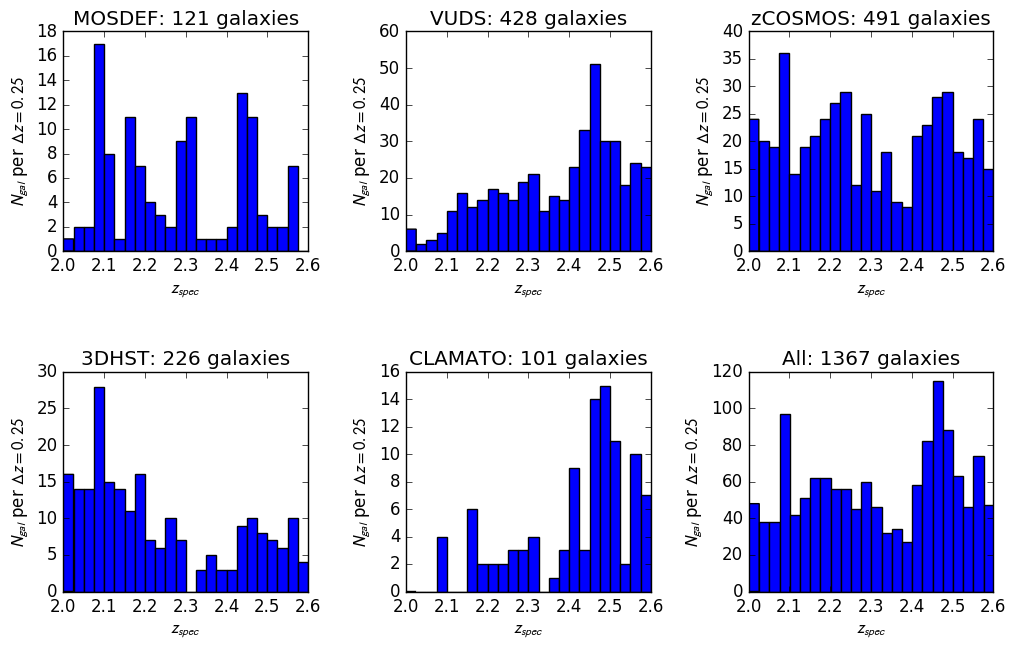

In [38]:
# Make subplots of all dNdz

fig, ((ax1, ax2, ax3),(ax4,ax5,ax6))= plt.subplots(2,3, figsize=(12,7))

zmin=2.0
zmax=2.6
binwidth=0.025

xlab_str = r'$z_{spec}$'
ylab_str = r'$N_{gal}$'+' per '+r'$\Delta z=0.25$'

ax1.set_xlim(zmin,zmax)
ax1.set_xlabel(xlab_str)
ax1.set_ylabel(ylab_str)
ax1.set_title("MOSDEF: %i galaxies" % len(catmddata))
ax1.hist(catmddata['Z_MOSFIRE'],bins=np.arange(zmin, zmax + binwidth, binwidth))

ax2.set_xlim(zmin,zmax)
ax2.set_xlabel(xlab_str)
ax2.set_ylabel(ylab_str)
ax2.set_title("VUDS: %i galaxies" % len(vuds))
ax2.hist(vuds['z_spec'],bins=np.arange(zmin, zmax + binwidth, binwidth))

ax3.set_xlim(zmin,zmax)
ax3.set_xlabel(xlab_str)
ax3.set_ylabel(ylab_str)
ax3.set_title("zCOSMOS: %i galaxies" % len(cosmos))
ax3.hist(cosmos['z_spec'],bins=np.arange(zmin, zmax + binwidth, binwidth))

ax4.set_xlim(zmin,zmax)
ax4.set_xlabel(xlab_str)
ax4.set_ylabel(ylab_str)
ax4.set_title("3DHST: %i galaxies" % len(phot3d))
ax4.hist(grism3d['z_max_grism'],bins=np.arange(zmin, zmax + binwidth, binwidth))

ax5.set_xlim(zmin,zmax)
ax5.set_xlabel(xlab_str)
ax5.set_ylabel(ylab_str)
ax5.set_title("CLAMATO: %i galaxies" % len(clamato))
ax5.hist(clamato['zspec'],bins=np.arange(zmin, zmax + binwidth, binwidth))

ax6.set_xlim(zmin,zmax)
ax6.set_xlabel(xlab_str)
ax6.set_ylabel(ylab_str)
ax6.set_title("All: %i galaxies" % len(z_all))
ax6.hist(z_all,bins=np.arange(min(z_all), max(z_all) + binwidth, binwidth))

fig.subplots_adjust(hspace=0.55)
fig.subplots_adjust(wspace=0.4)

plt.show()